In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import random
from sklearn.utils import shuffle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import warp, SimilarityTransform, AffineTransform
from skimage import exposure
from sklearn.utils import shuffle
from numpy import random
from tensorflow.contrib.layers import flatten
import tensorflow as tf
import skimage
from skimage import io
from skimage import transform
from skimage.filters import gaussian
import glob
import pickle



In [32]:
# Load pickled data

training_file = './train.p'
validation_file= './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
#image preprocessing
def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)
def equalize_histogram(image):
    image= sharpen_img(image)
    image = image.astype(np.uint8)
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
    # equalize the histogram of the Y channel
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
    
    # convert the YUV image back to RGB format
    image_output = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    return image_output

def set_augment(X):
    aug_X = np.empty(shape=X.shape, dtype=np.uint8)
    for i, img in enumerate(X):
        aug_X[i] = equalize_histogram(img)
    return aug_X


# X_aug = set_augment(X_train)
# X_valid=set_augment(X_valid)
# X_test=set_augment(X_test)



This is the lable Id  7: Speed limit (100km/h) and random choose 10.


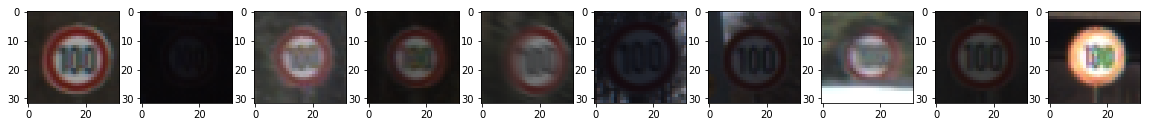

In [4]:
# Visualizations of the data
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
signnames = pd.read_csv('./signnames.csv')

with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    sign_names = list(reader)
    
labels = np.unique(y_train)
labelId=7 #number between 0 and 43
label_indices = np.where(y_train==labels[labelId])[0]
fig = plt.figure(figsize=(20, 20))
for i in range(10):
    rand_index = random.choice(label_indices)
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(X_train[rand_index], interpolation='nearest')
print("This is the lable Id  "+str(labels[labelId]) + ': ' + sign_names[labels[labelId]][1]+" and random choose 10.")
plt.show()
plt.savefig('./output_figures/after_process.png')

In [5]:

from sklearn.utils import shuffle
X_train, y_train= shuffle(X_train, y_train)

In [6]:


EPOCHS = 50
BATCH_SIZE = 128

In [34]:
#build the NN model
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W= tf.Variable(tf.truncated_normal(shape=(5,5,3,6), mean=mu, stddev=sigma))
    conv1_b= tf.Variable(tf.zeros(6))
    conv1= tf.nn.conv2d(x,conv1_W,strides=[1,1,1,1],padding='VALID',use_cudnn_on_gpu=True) + conv1_b

    # Activation.
    conv1= tf.nn.relu(conv1)

    # Layer 2: Convolutional. Input = 28x28x6. Output = 24x24x10.
    conv2_W= tf.Variable(tf.truncated_normal(shape=(5,5,6,10), mean=mu, stddev=sigma))
    conv2_b= tf.Variable(tf.zeros(10))
    conv2= tf.nn.conv2d(conv1,conv2_W,strides=[1,1,1,1],padding='VALID',use_cudnn_on_gpu=True) + conv2_b

    # Activation.
    conv2= tf.nn.relu(conv2)

    # Layer 3: Convolutional. Input = 14x14x10. Output = 8x8x16.
    conv3_W= tf.Variable(tf.truncated_normal(shape=(5,5,10,16),mean=mu,stddev=sigma))
    conv3_b=tf.Variable(tf.zeros(16))
    conv3= tf.nn.conv2d(conv2,conv3_W,strides=[1,1,1,1],padding='VALID',use_cudnn_on_gpu=True) + conv3_b
    
    # Activation.
    conv3= tf.nn.relu(conv3)

    # Pooling. Input = 8x8x16. Output = 4x4x16.
    conv3= tf.nn.max_pool(conv3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

    # Flatten. Input = 4x4x16. Output = 256.
    f= flatten(conv3)

    # Layer 4: Fully Connected. Input = 256. Output = 120.
    fc1_W= tf.Variable(tf.truncated_normal(shape=(int(np.shape(f)[1]),120),mean=mu,stddev=sigma))
    fc1_b= tf.Variable(tf.zeros(shape=120))
    fc1= tf.matmul(f,fc1_W) + fc1_b
    
    # Activation.
    fc1= tf.nn.relu(fc1)
    
    # Introduce Dropout after first fully connected layer
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 100.
    fc2_W= tf.Variable(tf.truncated_normal(shape=(120,100),mean=mu,stddev=sigma))
    fc2_b= tf.Variable(tf.zeros(100))
    fc2= tf.matmul(fc1,fc2_W) + fc2_b
    
    # Activation.
    fc2= tf.nn.relu(fc2)

    
    # Layer 6: Fully Connected. Input = 100. Output = 84.
    fc3_W= tf.Variable(tf.truncated_normal(shape=(100,84),mean=mu,stddev=sigma))
    fc3_b= tf.Variable(tf.zeros(84))
    fc3= tf.matmul(fc2,fc3_W) + fc3_b
    
    
    # Activation.
    fc3= tf.nn.relu(fc3)
    
    # Layer 7: Fully Connected. Input = 84. Output = 43.
    fc4_W= tf.Variable(tf.truncated_normal(shape=(84,43),mean=mu,stddev=sigma))
    fc4_b= tf.Variable(tf.zeros(43))
    
    logits = tf.matmul(fc3,fc4_W) + fc4_b
        
    return logits

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43) # one hot encoding for output labels
keep_prob = tf.placeholder(tf.float32) # defining the dropout probability after fully connected layer in the architecture
print('Variables initialized successfully')

Variables initialized successfully


In [9]:


rate = 0.001 #learning rate

#defining various operations
logits = LeNet(x) 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)




In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss=0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy,loss = sess.run([accuracy_operation,loss_operation],feed_dict={x: batch_x, y: batch_y,keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
        total_loss+= (loss*len(batch_x)) # getting the total loss to plot a graph later
    return total_accuracy / num_examples, total_loss/num_examples

In [11]:
valid_accuracy=[]
train_accuracy=[]
errors = list()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    loss_Acc=[]
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train )
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.5})
            
        validation_accuracy,loss_acc= evaluate(X_valid, y_valid)
        training_accuracy,_ = evaluate(X_train, y_train)
        valid_accuracy.append(validation_accuracy)
        train_accuracy.append(training_accuracy)
        errors.append((training_accuracy,validation_accuracy))
       
        print("EPOCH {} ...".format(i+1))
        loss_Acc.append(loss_acc)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    print("Model saved")
    saver.save(sess, './lenet')

Training...

EPOCH 1 ...
Validation Accuracy = 0.483

EPOCH 2 ...
Validation Accuracy = 0.723

EPOCH 3 ...
Validation Accuracy = 0.815

EPOCH 4 ...
Validation Accuracy = 0.868

EPOCH 5 ...
Validation Accuracy = 0.887

EPOCH 6 ...
Validation Accuracy = 0.904

EPOCH 7 ...
Validation Accuracy = 0.920

EPOCH 8 ...
Validation Accuracy = 0.939

EPOCH 9 ...
Validation Accuracy = 0.940

EPOCH 10 ...
Validation Accuracy = 0.946

EPOCH 11 ...
Validation Accuracy = 0.945

EPOCH 12 ...
Validation Accuracy = 0.949

EPOCH 13 ...
Validation Accuracy = 0.952

EPOCH 14 ...
Validation Accuracy = 0.952

EPOCH 15 ...
Validation Accuracy = 0.951

EPOCH 16 ...
Validation Accuracy = 0.951

EPOCH 17 ...
Validation Accuracy = 0.954

EPOCH 18 ...
Validation Accuracy = 0.951

EPOCH 19 ...
Validation Accuracy = 0.967

EPOCH 20 ...
Validation Accuracy = 0.960

EPOCH 21 ...
Validation Accuracy = 0.955

EPOCH 22 ...
Validation Accuracy = 0.964

EPOCH 23 ...
Validation Accuracy = 0.963

EPOCH 24 ...
Validation Accura

In [12]:

# Check Test Accuracy
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_valid, y_valid)
    print("valid Accuracy = {:.3f}".format(test_accuracy[0]))

INFO:tensorflow:Restoring parameters from ./lenet
valid Accuracy = 0.963


In [13]:
# Check Test Accuracy
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.952


In [14]:
# Check Test Accuracy
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(test_accuracy[0]))

INFO:tensorflow:Restoring parameters from ./lenet
Train Accuracy = 0.999


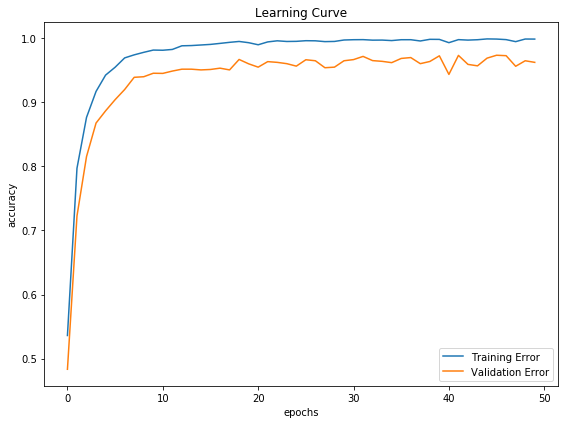

test_accuracy0.998936751056.png


In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Learning Curve')
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training Error','Validation Error'])
plt.tight_layout()
plt.show()
name="test_accuracy"+str(test_accuracy[0])+".png"
print(name)
plt.savefig('./output_figures/name')

In [16]:
from PIL import Image
import matplotlib.image as mpimg
i=1
images_wild = []
labels_wild = []
for line in open('./online_traffic_signs/data.txt','r'):
    fname, label = line.strip().split(' ')
    fname = 'online_traffic_signs/'+fname
    label = int(label)
    image = Image.open(fname)
    new_image = image.resize((32, 32))
    rgb_image = new_image .convert('RGB')
    images_wild.append( rgb_image)
    labels_wild.append(label)

In [17]:
images = np.concatenate(images_wild,axis=0)
images.shape
images=np.reshape(images, (5,32,32,3))
images.shape

(5, 32, 32, 3)

In [18]:
yy_test=y_test
yy_test[0:5]=labels_wild 
labels=yy_test[0:5]
labels.shape

(5,)

In [30]:
# Check Test Accuracy
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(images, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.800


INFO:tensorflow:Restoring parameters from ./lenet


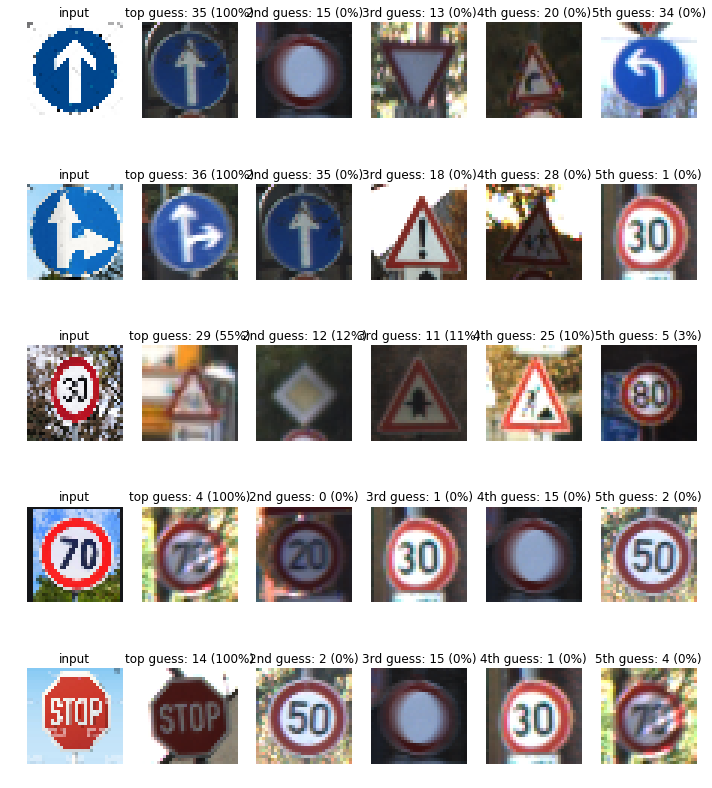

In [33]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)
keep_prob2 = tf.placeholder(tf.float32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: images, keep_prob: 1.0, keep_prob2:1.0})
    my_top_k = sess.run(top_k, feed_dict={x:images, keep_prob: 1.0, keep_prob2:1.0})
 
    fig, axs = plt.subplots(len(images),6, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(images):
        axs[6*i].axis('off')
        axs[6*i].imshow(image)
        axs[6*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_test == guess1)[0]
        axs[6*i+1].axis('off')
        axs[6*i+1].imshow(X_test[index1].squeeze(), cmap='gray')
        axs[6*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_test == guess2)[0]
        axs[6*i+2].axis('off')
        axs[6*i+2].imshow(X_test[index2].squeeze(), cmap='gray')
        axs[6*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_test == guess3)[0]
        axs[6*i+3].axis('off')
        axs[6*i+3].imshow(X_test[index3].squeeze(), cmap='gray')
        axs[6*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))
        
        guess4 = my_top_k[1][i][3]
        index4 = np.argwhere(y_test == guess4)[0]
        axs[6*i+4].axis('off')
        axs[6*i+4].imshow(X_test[index4].squeeze(), cmap='gray')
        axs[6*i+4].set_title('4th guess: {} ({:.0f}%)'.format(guess4, 100*my_top_k[0][i][3]))
        
        guess5 = my_top_k[1][i][4]
        index5 = np.argwhere(y_test == guess5)[0]
        axs[6*i+5].axis('off')
        axs[6*i+5].imshow(X_test[index5].squeeze(), cmap='gray')
        axs[6*i+5].set_title('5th guess: {} ({:.0f}%)'.format(guess5, 100*my_top_k[0][i][4]))